# DeepHubble

Here, we are exploring the Pro-GAN as describes in [this paper](https://arxiv.org/pdf/1710.10196.pdf)

In [1]:
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
import torchx
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from PIL import Image

## Data

The ground truth data will be sampled from the Hubble eXtreme Deep Field (XDF). As seen below

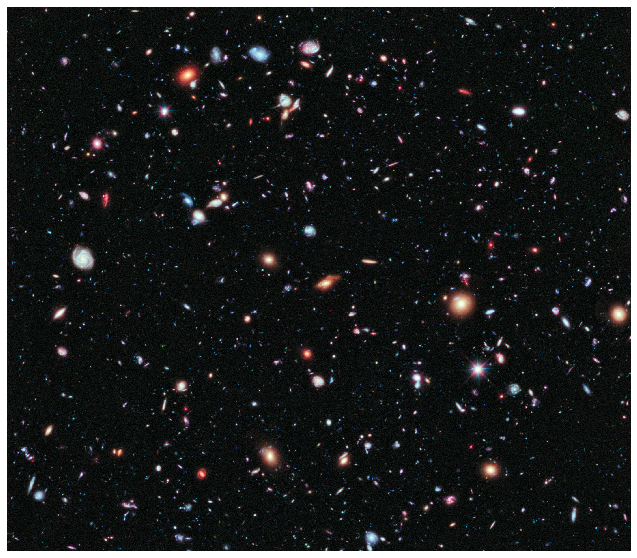

In [2]:
HubbleXDF = Image.open("../data/HubbleXDF_cropped.jpg")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(HubbleXDF)
plt.axis('off')
plt.show()

We will be sampling images from the deep field image for our model to learn the distribution for. For the purpose of progressively growing our GAN, we sample $512 \times 512$ images from the XDF and then scale it down to $4\times4$ and then scaling back up as we train. For example:

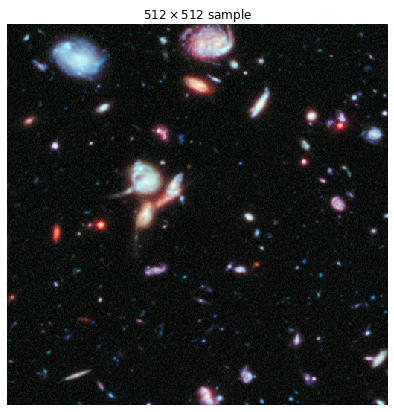

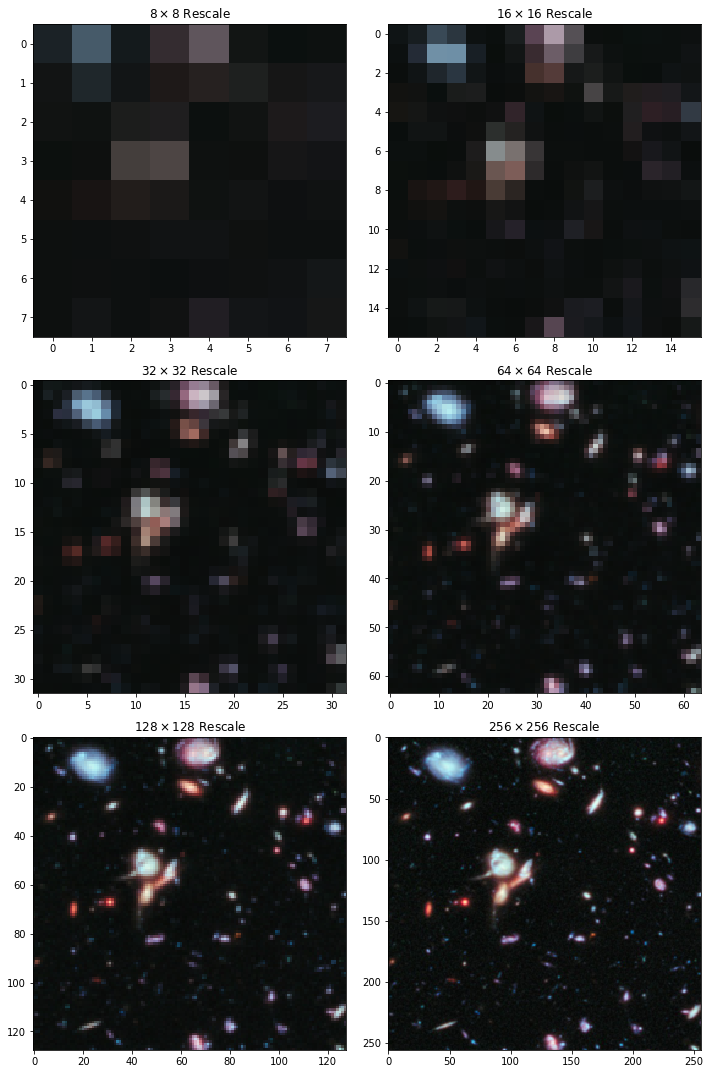

In [3]:
def sample_image(width, height):
    random.seed(20120925)  # Date the XDF was captured: September 25th, 2012
    return torchv.transforms.Compose([
        torchv.transforms.RandomCrop((512, 512)),
        torchv.transforms.Resize((width, height)),
    ])(HubbleXDF)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(sample_image(512, 512))
plt.axis("off")
plt.title(r"$512 \times 512$ sample")
plt.show()

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
fig.tight_layout()
ax[0][0].imshow(sample_image(8, 8))
ax[0][0].set_title(r"$8 \times 8$ Rescale")
ax[0][1].imshow(sample_image(16, 16))
ax[0][1].set_title(r"$16 \times 16$ Rescale")
ax[1][0].imshow(sample_image(32, 32))
ax[1][0].set_title(r"$32 \times 32$ Rescale")
ax[1][1].imshow(sample_image(64, 64))
ax[1][1].set_title(r"$64 \times 64$ Rescale")
ax[2][0].imshow(sample_image(128, 128))
ax[2][0].set_title(r"$128 \times 128$ Rescale")
ax[2][1].imshow(sample_image(256, 256))
ax[2][1].set_title(r"$256 \times 256$ Rescale")
plt.show()

In [4]:
class Dataset:
    def __init__(self, dim=64, size=96000):
        self.dim = dim
        self.size = size
        
        self.transforms = torchv.transforms.Compose([
            torchv.transforms.RandomCrop((512, 512)),
            torchv.transforms.Resize((self.dim, self.dim)),
            torchv.transforms.ToTensor()
        ])
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.transforms(HubbleXDF)
    
def FromTensor(tensor):
    return np.moveaxis(tensor.detach().cpu().numpy(), 1, -1)

## Model Architectures

The architectures for the generator and discriminator models for the samples are as follows:

In [ ]:
dim = 256

In [ ]:
class Generator(torchx.nn.Module):
    def __init__(self, input_size=100, output_channels=3):
        super().__init__()
        
        self.input_size = input_size
        self.output_channels = output_channels
        
        self.conv_transpose_8x8 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(self.input_size, 64, 4, 1, 0),
            torchx.nn.ConvTranspose2dBatch(64, 256, 4, 2, 1),
        )
        self.conv_transpose_16x16 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.conv_transpose_32x32 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.conv_transpose_64x64 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.conv_transpose_128x128 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.conv_transpose_256x256 = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(256, 256, 4, 2, 1),
            torchx.nn.ConvTranspose2dBatch(256, 256, 3, 1, 1),
        )
        self.final = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, self.output_channels, 3, 1, 1),
            torch.nn.Sigmoid()
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = x.view(-1, self.input_size, 1, 1)
        x = self.conv_transpose_8x8(x)
        x = self.conv_transpose_16x16(x)
        x = self.conv_transpose_32x32(x)
        x = self.conv_transpose_64x64(x)
        x = self.conv_transpose_128x128(x)
        x = self.conv_transpose_256x256(x)
        return self.final(x)
    

generator = Generator().cuda()
generator.load(f"../data/checkpoints/final_generator_{dim//2}.pt")
print("Number of Parameters for Generator: ", generator.num_params())

Number of Parameters for Generator:  8569219


In [ ]:
noise = torch.rand([1, 100]).cuda()
assert generator.forward(noise).shape == (1, 3, dim, dim), \
    f"{generator.forward(noise).shape} != {(1, 3, dim, dim)}"

In [ ]:
class Discriminator(torchx.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        self.input_channels = input_channels

        def Conv2dBatchLeaky(
            in_channels: int,
            out_channels: int,
            kernel_size: int = 3,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
            leaky=0.2,
            **kwargs
        ):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(leaky, inplace=True),
            )
        
        self.conv_8x8 = torch.nn.Sequential(
            Conv2dBatchLeaky(self.input_channels, 256, 4, 2, 1),
            Conv2dBatchLeaky(256, 256, 3, 1, 1),
        )
        self.conv_16x16 = (
            Conv2dBatchLeaky(256, 256, 4, 2, 1)
        )
        self.conv_32x32 = torch.nn.Sequential(
            Conv2dBatchLeaky(256, 256, 3, 1, 1),
            Conv2dBatchLeaky(256, 256, 4, 2, 1)
        )
        self.conv_64x64 = torch.nn.Sequential(
            Conv2dBatchLeaky(256, 256, 3, 1),
            Conv2dBatchLeaky(256, 256, 3, 1),
        )
        self.conv_128x128 = torch.nn.Sequential(
            Conv2dBatchLeaky(256, 256, 3, 1),
            Conv2dBatchLeaky(256, 256, 4, 2),
        )
        self.conv_256x256 = torch.nn.Sequential(
            Conv2dBatchLeaky(256, 256, 3, 1),
            Conv2dBatchLeaky(256, 256, 4, 2),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = self.conv_8x8(x)
        x = self.conv_16x16(x)
        x = self.conv_32x32(x)
        x = self.conv_64x64(x)
        x = self.conv_128x128(x)
        x = self.conv_256x256(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return torch.flatten(x, 0)
    

discriminator = Discriminator().cuda()
discriminator.load(f"../data/checkpoints/final_discriminator_{dim//2}.pt")
print("Number of Parameters for Discriminator: ", discriminator.num_params())

Number of Parameters for Discriminator:  7755264


In [ ]:
imgs = torch.rand([1, 3, dim, dim]).cuda()
prediction = discriminator.forward(imgs)
assert prediction.shape == (1,), f"{prediction.shape} != (1,)"

## Initial Output

As we can see, initially, the generator model outputs random noise

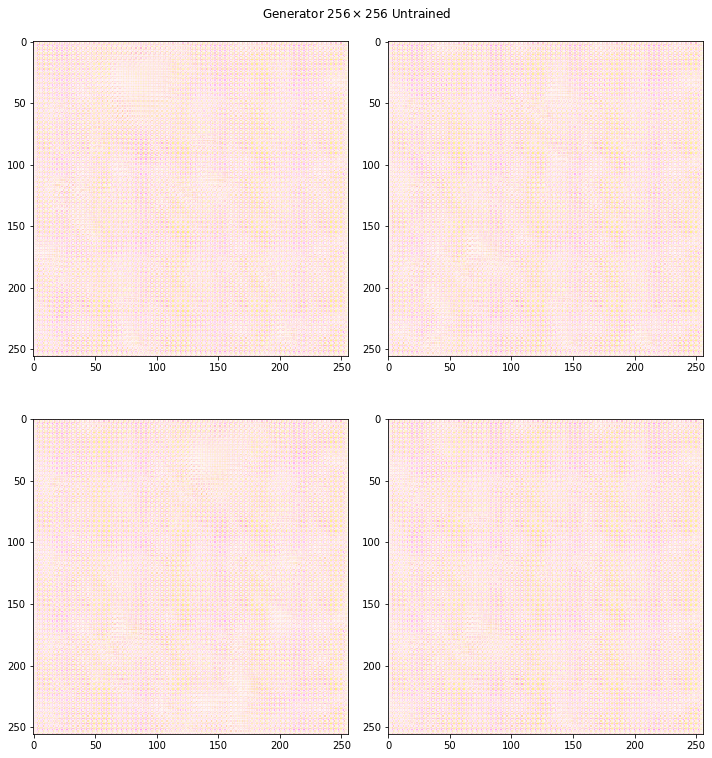

In [ ]:
noise = torch.randn(4, 100).cuda()
fake_output = generator.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(10, 11))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
fig.suptitle(f"Generator ${dim} \\times {dim}$ Untrained")
fig.tight_layout()
plt.savefig(f"../data/images/generator_untrained_{dim}x{dim}.png")
plt.show()

## Training

In [ ]:
dataloader = torch.utils.data.DataLoader(
    Dataset(dim=dim, size=2400),
    batch_size=4,
    num_workers=0,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [ ]:
criterion = torch.nn.BCELoss()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

min_average_generator_loss = np.inf
min_average_discriminator_loss = np.inf

generator_losses = []
discriminator_losses = []

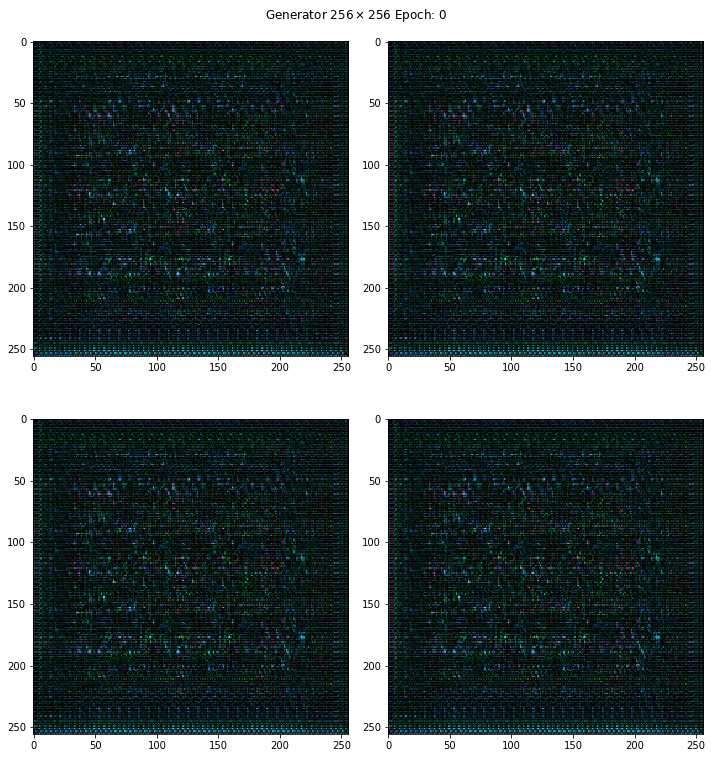

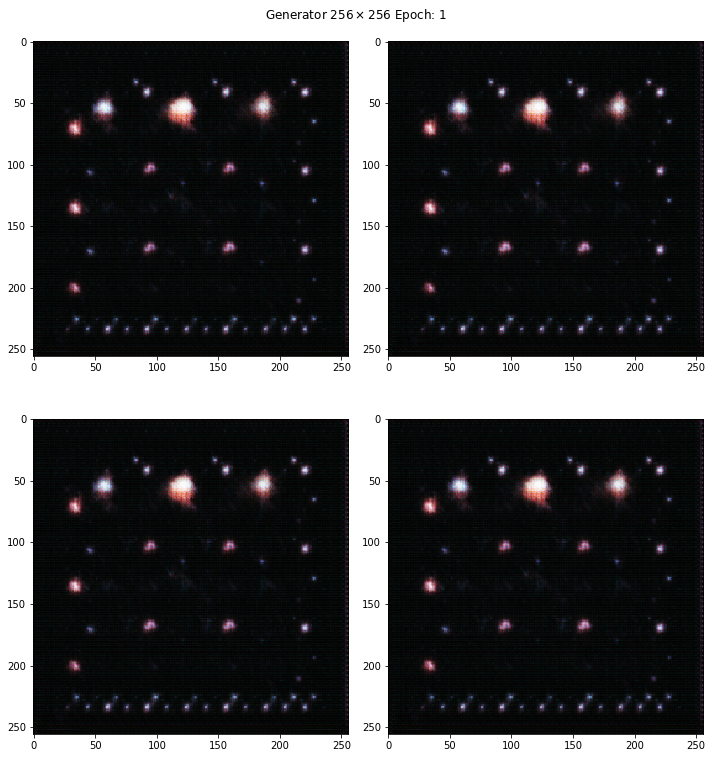

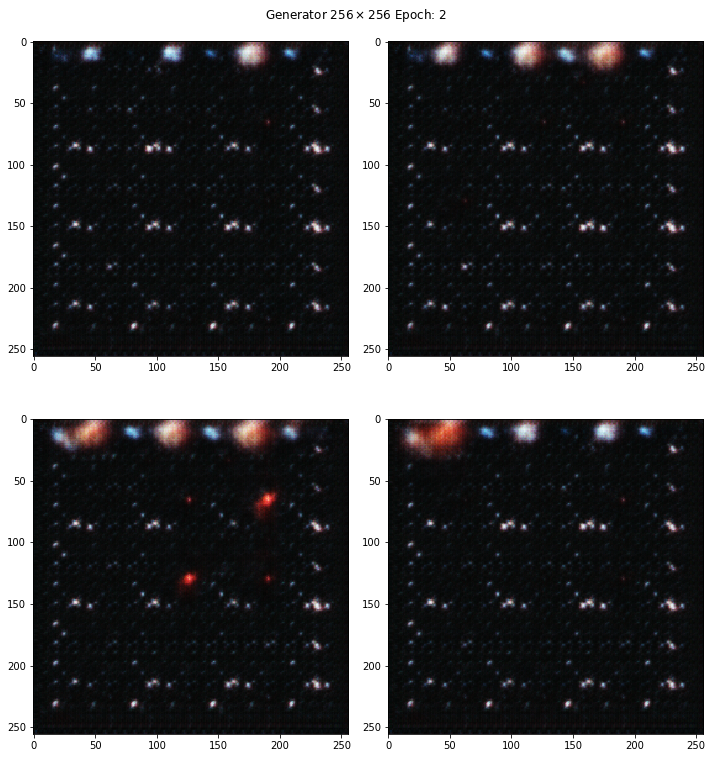

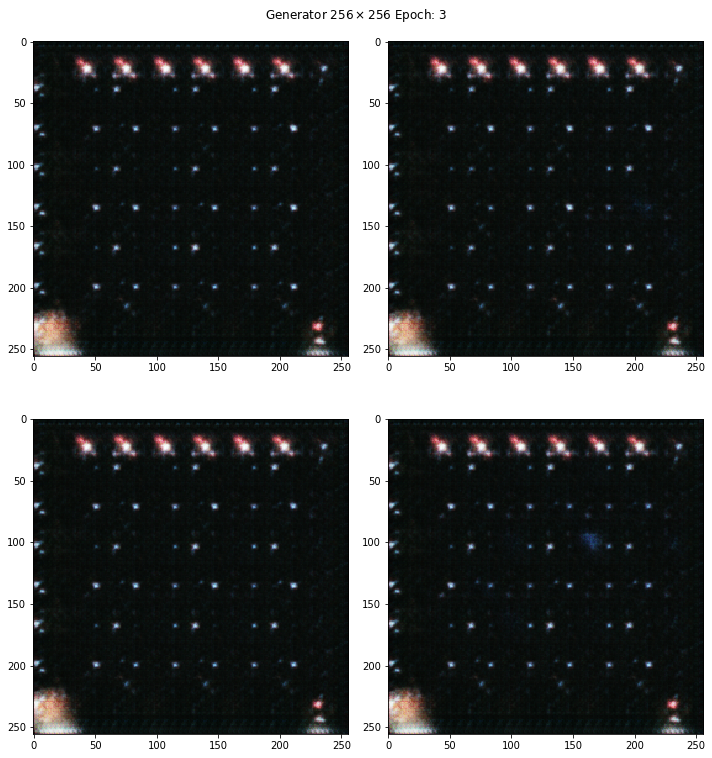

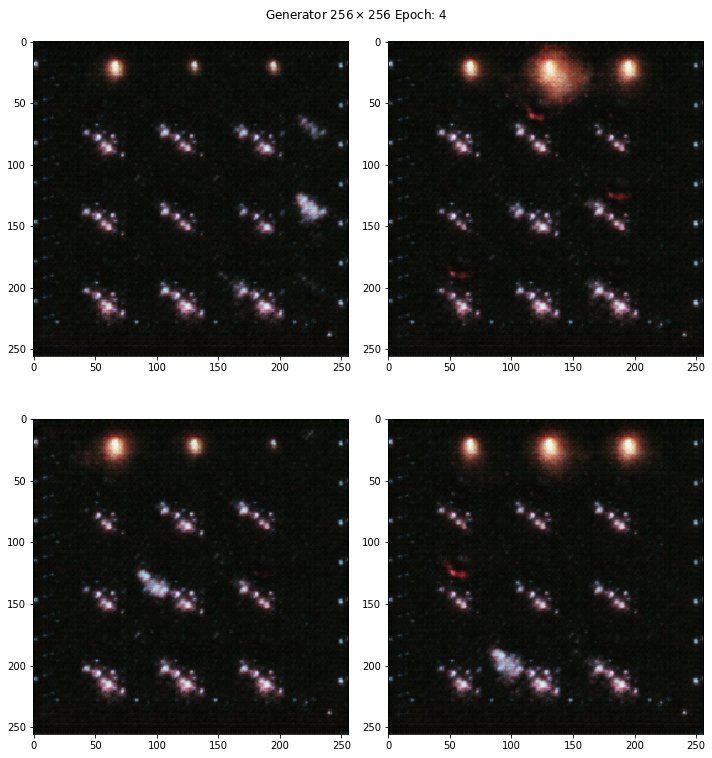

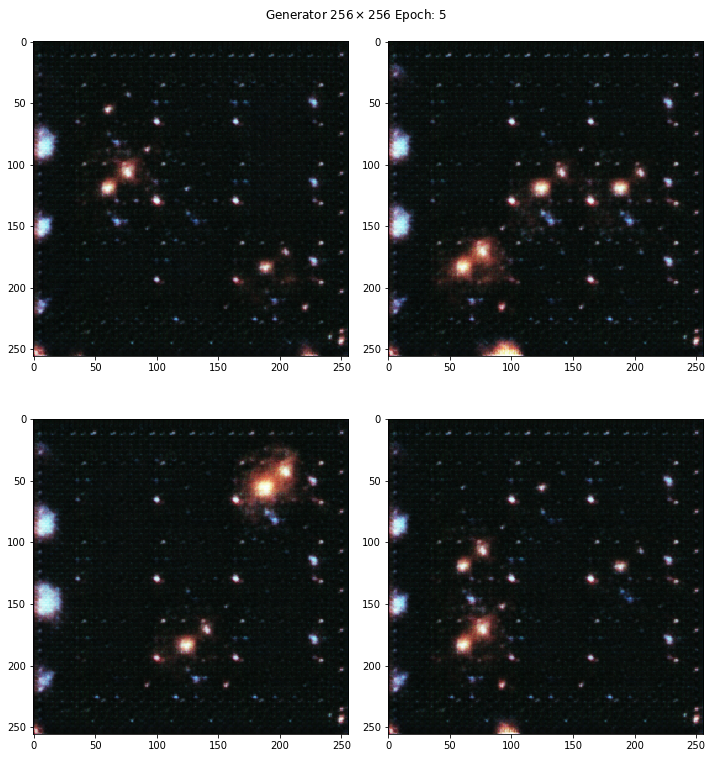

In [ ]:
epochs = 10

for epoch in trange(epochs):
    with tqdm(total=len(dataloader), leave=False) as progress:
        generator.train()
        discriminator.train()
        progress.set_description(f"epoch {epoch+1}")

        generator_loss = 0
#             discriminator_loss = 0

        zero_label = torch.zeros(dataloader.batch_size).cuda()
        one_label = (torch.ones(dataloader.batch_size) * 0.9).cuda()

        for i, imgs in enumerate(dataloader):
            imgs = imgs.cuda()

            discriminator.zero_grad()

            real_output = discriminator.forward(imgs)
            discriminator_err_real = criterion(real_output, one_label)

            noise = torch.randn(imgs.shape[0], 100).cuda()
            fake_output = generator.forward(noise)
            discriminator_err_fake = criterion(
                discriminator.forward(fake_output.detach()), 
                zero_label
            )

            discriminator_err = discriminator_err_real + discriminator_err_fake
            discriminator_err_real.backward(retain_graph=True)
            discriminator_err_fake.backward()
            discriminator_optimizer.step()

            generator.zero_grad()

            generator_err = criterion(discriminator.forward(fake_output), one_label)
            generator_err.backward()
            generator_optimizer.step()

            progress.set_postfix(dloss="%.6f" % discriminator_err.item(), gloss="%.6f" % generator_err.item())
            progress.update()

            if discriminator_err.item() > 50:
                raise Exception("Training has diverged.")

            generator_losses.append(generator_err.item())
            discriminator_losses.append(discriminator_err.item())

            generator_loss += generator_err.item()
#                 discriminator_loss += discriminator_err.item()
            if i % 5 == 0:
                time.sleep(1)

        generator_loss /= len(dataloader)
#             discriminator_loss /= len(dataloader)

        if generator_loss < min_average_generator_loss:
            min_average_generator_loss = generator_loss
            generator.save(f"../data/checkpoints/best_generator_{dim}.pt")
            discriminator.save(f"../data/checkpoints/best_discriminator_{dim}.pt")
            
    noise = torch.randn(4, 100).cuda()
    fake_output = generator.forward(noise)
    fake_output = FromTensor(fake_output)

    fig, ax = plt.subplots(2, 2, figsize=(10, 11))
    fig.tight_layout()
    ax[0][0].imshow(fake_output[0])
    ax[0][1].imshow(fake_output[1])
    ax[1][0].imshow(fake_output[2])
    ax[1][1].imshow(fake_output[3])
    fig.suptitle(f"Generator ${dim} \\times {dim}$ Epoch: {epoch}")
    fig.tight_layout()
    plt.show()

In [ ]:
pd.DataFrame({
    "Generator": generator_losses,
    "Discriminator": discriminator_losses
}).rolling(10).mean().plot(title="Training Losses")
plt.show()

## Generating 256x256 Images

After training, we can use the generator to generate images and see what the generator has learnt

In [ ]:
noise = torch.randn(4, 100).cuda()
fake_output = generator.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(10, 11))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
fig.suptitle(f"Generator ${dim} \\times {dim}$ Trained")
fig.tight_layout()
plt.savefig(f"../data/images/generator_trained_{dim}x{dim}.png")
plt.show()

In [ ]:
real_imgs = next(iter(dataloader))
real_imgs = FromTensor(real_imgs)

fig, ax = plt.subplots(2, 2, figsize=(10, 11))
fig.tight_layout()
ax[0][0].imshow(real_imgs[0])
ax[0][1].imshow(real_imgs[1])
ax[1][0].imshow(real_imgs[2])
ax[1][1].imshow(real_imgs[3])
plt.show()